### Data visualization(2)

- EDA by location with coordinates
- reverse geocoding: longitude & lattitude => address


- Shp file
    - saved at 'bigquery-public-data.geo_us_boundaries.zip_codes'
    - if pickup_logitude, pickup_latitude belongs zip_code_geom, it's the location

In [1]:
import chart_studio.plotly as py
import cufflinks as cf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
print(cf.__version__)
cf.go_offline()
%config InlineBackend.figure_format = 'retina'

0.17.3


In [2]:
# import GCP Client library
from google.cloud import bigquery

#instantiate a client for bigquery service
bigquery_client = bigquery.Client()

In [3]:
query = """
WITH base_data AS (
  SELECT 
    *
  FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
  WHERE EXTRACT(MONTH from pickup_datetime) = 1
), temp AS (
  SELECT nyc_taxi.*, gis.* 
  FROM (
    SELECT *
    FROM base_data
    WHERE pickup_latitude  <= 90 and pickup_latitude >= -90
    ) as nyc_taxi
  JOIN (
    SELECT zip_code, state_code, state_name, city, county, zip_code_geom
    FROM `bigquery-public-data.geo_us_boundaries.zip_codes`
    WHERE state_code='NY'
    ) as gis 
  ON st_contains(zip_code_geom, st_geogpoint(pickup_longitude, pickup_latitude))
)

SELECT 
  zip_code, 
  city,
  ST_ASTEXT(zip_code_geom) as zip_code_geom,
  DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour,
  count(*) as cnt
FROM temp
GROUP BY zip_code, city, zip_code_geom, pickup_hour
ORDER BY pickup_hour

"""

In [4]:
# run query and get data from bigquery
query_job = bigquery_client.query(query) #API request

# data into dataframe
df = query_job.to_dataframe()
df.head(100)

,zip_code,city,zip_code_geom,pickup_hour,cnt
0,10005,New York city,"POLYGON((-74.012508 40.706767, -74.0124 40.706...",2015-01-01,105
1,10174,New York city,"POLYGON((-73.975558 40.752116, -73.976048 40.7...",2015-01-01,16
2,10453,New York city,"POLYGON((-73.92815 40.845507, -73.928159 40.84...",2015-01-01,4
3,11104,New York city,"POLYGON((-73.927635 40.736597, -73.927441 40.7...",2015-01-01,35
4,11373,New York city,"POLYGON((-73.891746 40.742138, -73.891337 40.7...",2015-01-01,14
...,...,...,...,...,...
95,10034,New York city,"POLYGON((-73.946859 40.850583, -73.947005 40.8...",2015-01-01,15
96,11109,New York city,"POLYGON((-73.961381 40.742802, -73.961328 40.7...",2015-01-01,23
97,11105,New York city,"POLYGON((-73.921395 40.778454, -73.922002 40.7...",2015-01-01,32
98,10168,New York city,"POLYGON((-73.977677 40.752119, -73.978159 40.7...",2015-01-01,32


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87020 entries, 0 to 87019
Data columns (total 5 columns):
zip_code         87020 non-null object
city             87020 non-null object
zip_code_geom    87020 non-null object
pickup_hour      87020 non-null datetime64[ns]
cnt              87020 non-null int64
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 3.3+ MB


### which zip_code has highest Trip 

In [6]:
zip_code_agg_df = df.groupby(['zip_code', 'zip_code_geom'])[['cnt']].sum().reset_index()

In [7]:
zip_code_agg_df.head(10)

,zip_code,zip_code_geom,cnt
0,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",627563
1,10002,"POLYGON((-73.997504 40.714069, -73.9973 40.713...",234527
2,10003,"POLYGON((-73.999366 40.731323, -73.999604 40.7...",704598
3,10004,"MULTIPOLYGON(((-74.018008 40.705935, -74.01801...",59700
4,10005,"POLYGON((-74.012508 40.706767, -74.0124 40.706...",52454
5,10006,"POLYGON((-74.015834 40.706984, -74.015956 40.7...",35708
6,10007,"POLYGON((-74.013382 40.714408, -74.0137 40.713...",87112
7,10009,"POLYGON((-73.988451 40.723277, -73.988643 40.7...",252903
8,10010,"POLYGON((-73.993739 40.741617, -73.994028 40.7...",387908
9,10011,"POLYGON((-74.012285 40.74387, -74.012359 40.74...",647831


In [8]:
zip_code_agg_df['percent'] = (zip_code_agg_df[['cnt']]/df[['cnt']].sum()).round(3).rename(columns={'cnt':'percent'}).reset_index()['percent']

In [9]:
zip_code_agg_df.head(10)

,zip_code,zip_code_geom,cnt,percent
0,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",627563,0.051
1,10002,"POLYGON((-73.997504 40.714069, -73.9973 40.713...",234527,0.019
2,10003,"POLYGON((-73.999366 40.731323, -73.999604 40.7...",704598,0.057
3,10004,"MULTIPOLYGON(((-74.018008 40.705935, -74.01801...",59700,0.005
4,10005,"POLYGON((-74.012508 40.706767, -74.0124 40.706...",52454,0.004
5,10006,"POLYGON((-74.015834 40.706984, -74.015956 40.7...",35708,0.003
6,10007,"POLYGON((-74.013382 40.714408, -74.0137 40.713...",87112,0.007
7,10009,"POLYGON((-73.988451 40.723277, -73.988643 40.7...",252903,0.021
8,10010,"POLYGON((-73.993739 40.741617, -73.994028 40.7...",387908,0.031
9,10011,"POLYGON((-74.012285 40.74387, -74.012359 40.74...",647831,0.053


In [10]:
zip_code_agg_df.tail(10)

,zip_code,zip_code_geom,cnt,percent
364,12601,"MULTIPOLYGON(((-73.919145 41.677197, -73.91913...",1,0.0
365,12729,"POLYGON((-74.673656 41.496556, -74.697836 41.4...",1,0.0
366,12771,"POLYGON((-74.726018 41.396123, -74.726008 41.3...",1,0.0
367,13029,"POLYGON((-76.212177 43.241684, -76.213393 43.2...",1,0.0
368,13118,"POLYGON((-76.543327 42.783988, -76.543272 42.7...",1,0.0
369,13656,"POLYGON((-76.067267 44.140696, -76.067236 44.1...",1,0.0
370,13691,"POLYGON((-75.88536 44.23349, -75.88501 44.2310...",1,0.0
371,14072,"MULTIPOLYGON(((-78.935536 42.965442, -78.93553...",1,0.0
372,14527,"MULTIPOLYGON(((-77.121905 42.624718, -77.12188...",1,0.0
373,14801,"POLYGON((-77.442016 42.140918, -77.44193 42.14...",1,0.0


In [11]:
# remove if percent <= 0
filter_agg_df = zip_code_agg_df[zip_code_agg_df['percent'] > 0.000]

In [12]:
filter_agg_df

,zip_code,zip_code_geom,cnt,percent
0,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",627563,0.051
1,10002,"POLYGON((-73.997504 40.714069, -73.9973 40.713...",234527,0.019
2,10003,"POLYGON((-73.999366 40.731323, -73.999604 40.7...",704598,0.057
3,10004,"MULTIPOLYGON(((-74.018008 40.705935, -74.01801...",59700,0.005
4,10005,"POLYGON((-74.012508 40.706767, -74.0124 40.706...",52454,0.004
...,...,...,...,...
219,11231,"POLYGON((-74.02002 40.677049, -74.019892 40.67...",14605,0.001
226,11238,"POLYGON((-73.973648 40.687303, -73.973374 40.6...",9456,0.001
245,11371,"POLYGON((-73.889077 40.773574, -73.889424 40.7...",247923,0.020
250,11377,"POLYGON((-73.925808 40.73589, -73.925834 40.73...",13416,0.001


In [13]:
filter_agg_df['cnt'].sum()

12197865

In [14]:
filter_zip_code = filter_agg_df['zip_code'].to_list()

In [15]:
filter_zip_code

['10001',
 '10002',
 '10003',
 '10004',
 '10005',
 '10006',
 '10007',
 '10009',
 '10010',
 '10011',
 '10012',
 '10013',
 '10014',
 '10016',
 '10017',
 '10018',
 '10019',
 '10020',
 '10021',
 '10022',
 '10023',
 '10024',
 '10025',
 '10026',
 '10027',
 '10028',
 '10029',
 '10031',
 '10032',
 '10035',
 '10036',
 '10038',
 '10065',
 '10069',
 '10075',
 '10103',
 '10110',
 '10111',
 '10112',
 '10119',
 '10128',
 '10152',
 '10153',
 '10154',
 '10165',
 '10167',
 '10168',
 '10170',
 '10171',
 '10172',
 '10173',
 '10174',
 '10199',
 '10280',
 '10282',
 '11101',
 '11102',
 '11103',
 '11104',
 '11106',
 '11201',
 '11205',
 '11206',
 '11211',
 '11215',
 '11217',
 '11222',
 '11231',
 '11238',
 '11371',
 '11377',
 '11430']

In [16]:
zip_code_agg_df['cnt'].sum()

12322300

In [17]:
filter_agg_df.tail(10)

,zip_code,zip_code_geom,cnt,percent
195,11206,"POLYGON((-73.95733 40.700904, -73.957457 40.70...",9628,0.001
200,11211,"MULTIPOLYGON(((-73.955603 40.724041, -73.95567...",61907,0.005
204,11215,"POLYGON((-74.000995 40.654067, -74.002144 40.6...",12420,0.001
206,11217,"POLYGON((-73.990424 40.682694, -73.990867 40.6...",22778,0.002
211,11222,"POLYGON((-73.962672 40.736446, -73.962668 40.7...",13370,0.001
219,11231,"POLYGON((-74.02002 40.677049, -74.019892 40.67...",14605,0.001
226,11238,"POLYGON((-73.973648 40.687303, -73.973374 40.6...",9456,0.001
245,11371,"POLYGON((-73.889077 40.773574, -73.889424 40.7...",247923,0.020
250,11377,"POLYGON((-73.925808 40.73589, -73.925834 40.73...",13416,0.001
273,11430,"POLYGON((-73.832705 40.665406, -73.831781 40.6...",233390,0.019


In [18]:
filter_agg_df.sort_values(by='cnt', ascending=False)

,zip_code,zip_code_geom,cnt,percent
16,10019,"POLYGON((-74.003568 40.763799, -74.003767 40.7...",817267,0.066
2,10003,"POLYGON((-73.999366 40.731323, -73.999604 40.7...",704598,0.057
19,10022,"POLYGON((-73.977201 40.758538, -73.977655 40.7...",679831,0.055
13,10016,"POLYGON((-73.987298 40.744682, -73.987746 40.7...",663540,0.054
9,10011,"POLYGON((-74.012285 40.74387, -74.012359 40.74...",647831,0.053
...,...,...,...,...
194,11205,"POLYGON((-73.980649 40.701561, -73.980729 40.7...",8437,0.001
54,10167,"POLYGON((-73.975352 40.755303, -73.975807 40.7...",8186,0.001
45,10112,"POLYGON((-73.980426 40.759899, -73.980886 40.7...",8135,0.001
60,10173,"POLYGON((-73.979937 40.754783, -73.980395 40.7...",7966,0.001


In [19]:
filter_agg_df.to_csv('zip_code_ratio.csv', index=False)

### visualization form Kepler.gl
- [Kepler.gl](https://kepler.gl/demo)
- <img src="https://www.dropbox.com/s/v18lb654qhrqx9l/Screenshot%202019-10-12%2016.01.45.png?raw=1">

In [20]:
zip_df = df[['zip_code', 'zip_code_geom', 'pickup_hour', 'cnt']]
zip_df

,zip_code,zip_code_geom,pickup_hour,cnt
0,10005,"POLYGON((-74.012508 40.706767, -74.0124 40.706...",2015-01-01 00:00:00,105
1,10174,"POLYGON((-73.975558 40.752116, -73.976048 40.7...",2015-01-01 00:00:00,16
2,10453,"POLYGON((-73.92815 40.845507, -73.928159 40.84...",2015-01-01 00:00:00,4
3,11104,"POLYGON((-73.927635 40.736597, -73.927441 40.7...",2015-01-01 00:00:00,35
4,11373,"POLYGON((-73.891746 40.742138, -73.891337 40.7...",2015-01-01 00:00:00,14
...,...,...,...,...
87015,11415,"POLYGON((-73.843016 40.709176, -73.842204 40.7...",2015-01-31 23:00:00,1
87016,10463,"POLYGON((-73.924974 40.879144, -73.92465 40.87...",2015-01-31 23:00:00,1
87017,10174,"POLYGON((-73.975558 40.752116, -73.976048 40.7...",2015-01-31 23:00:00,16
87018,10016,"POLYGON((-73.987298 40.744682, -73.987746 40.7...",2015-01-31 23:00:00,1640


In [21]:
zip_df['date'] = zip_df['pickup_hour'].dt.date
zip_df

,zip_code,zip_code_geom,pickup_hour,cnt,date
0,10005,"POLYGON((-74.012508 40.706767, -74.0124 40.706...",2015-01-01 00:00:00,105,2015-01-01
1,10174,"POLYGON((-73.975558 40.752116, -73.976048 40.7...",2015-01-01 00:00:00,16,2015-01-01
2,10453,"POLYGON((-73.92815 40.845507, -73.928159 40.84...",2015-01-01 00:00:00,4,2015-01-01
3,11104,"POLYGON((-73.927635 40.736597, -73.927441 40.7...",2015-01-01 00:00:00,35,2015-01-01
4,11373,"POLYGON((-73.891746 40.742138, -73.891337 40.7...",2015-01-01 00:00:00,14,2015-01-01
...,...,...,...,...,...
87015,11415,"POLYGON((-73.843016 40.709176, -73.842204 40.7...",2015-01-31 23:00:00,1,2015-01-31
87016,10463,"POLYGON((-73.924974 40.879144, -73.92465 40.87...",2015-01-31 23:00:00,1,2015-01-31
87017,10174,"POLYGON((-73.975558 40.752116, -73.976048 40.7...",2015-01-31 23:00:00,16,2015-01-31
87018,10016,"POLYGON((-73.987298 40.744682, -73.987746 40.7...",2015-01-31 23:00:00,1640,2015-01-31


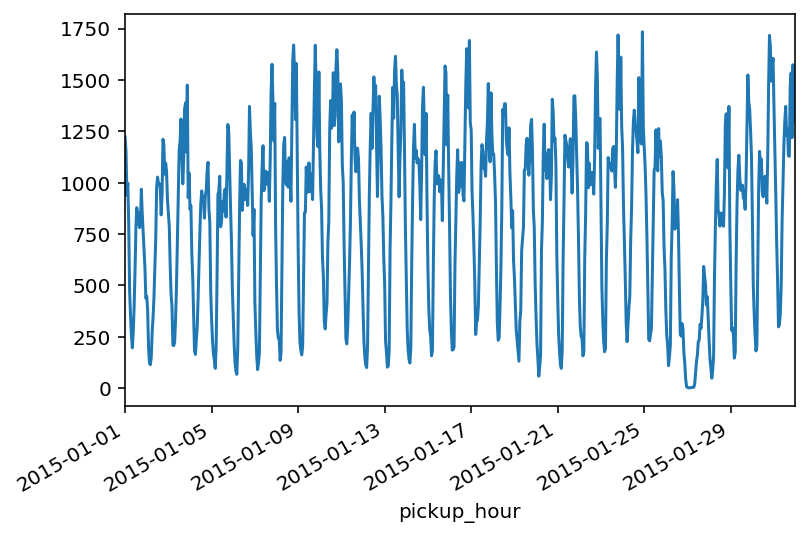

In [22]:
zip_df[zip_df['zip_code'] == '10001'].set_index('pickup_hour')['cnt'].plot()

### trip box plot per zip_code 

In [23]:
filter_zip_df = zip_df[zip_df['zip_code'].isin(filter_zip_code)]
filter_zip_df

,zip_code,zip_code_geom,pickup_hour,cnt,date
0,10005,"POLYGON((-74.012508 40.706767, -74.0124 40.706...",2015-01-01 00:00:00,105,2015-01-01
1,10174,"POLYGON((-73.975558 40.752116, -73.976048 40.7...",2015-01-01 00:00:00,16,2015-01-01
3,11104,"POLYGON((-73.927635 40.736597, -73.927441 40.7...",2015-01-01 00:00:00,35,2015-01-01
6,10165,"POLYGON((-73.979287 40.752801, -73.979768 40.7...",2015-01-01 00:00:00,39,2015-01-01
7,10029,"POLYGON((-73.955528 40.788245, -73.955778 40.7...",2015-01-01 00:00:00,204,2015-01-01
...,...,...,...,...,...
87011,10038,"POLYGON((-74.009988 40.709806, -74.010542 40.7...",2015-01-31 23:00:00,164,2015-01-31
87014,10018,"POLYGON((-74.006685 40.759917, -74.007203 40.7...",2015-01-31 23:00:00,566,2015-01-31
87017,10174,"POLYGON((-73.975558 40.752116, -73.976048 40.7...",2015-01-31 23:00:00,16,2015-01-31
87018,10016,"POLYGON((-73.987298 40.744682, -73.987746 40.7...",2015-01-31 23:00:00,1640,2015-01-31


In [24]:
filter_zip_daily_df = filter_zip_df.groupby(['zip_code', 'date'])[['cnt']].sum().reset_index()
filter_zip_daily_df

,zip_code,date,cnt
0,10001,2015-01-01,16770
1,10001,2015-01-02,17046
2,10001,2015-01-03,20478
3,10001,2015-01-04,16743
4,10001,2015-01-05,17441
...,...,...,...
2227,11430,2015-01-27,1345
2228,11430,2015-01-28,7727
2229,11430,2015-01-29,7527
2230,11430,2015-01-30,7079


In [25]:
filter_zip_daily_df.pivot_table('cnt', index='date', columns='zip_code').iplot(kind='box', x='zip_code')

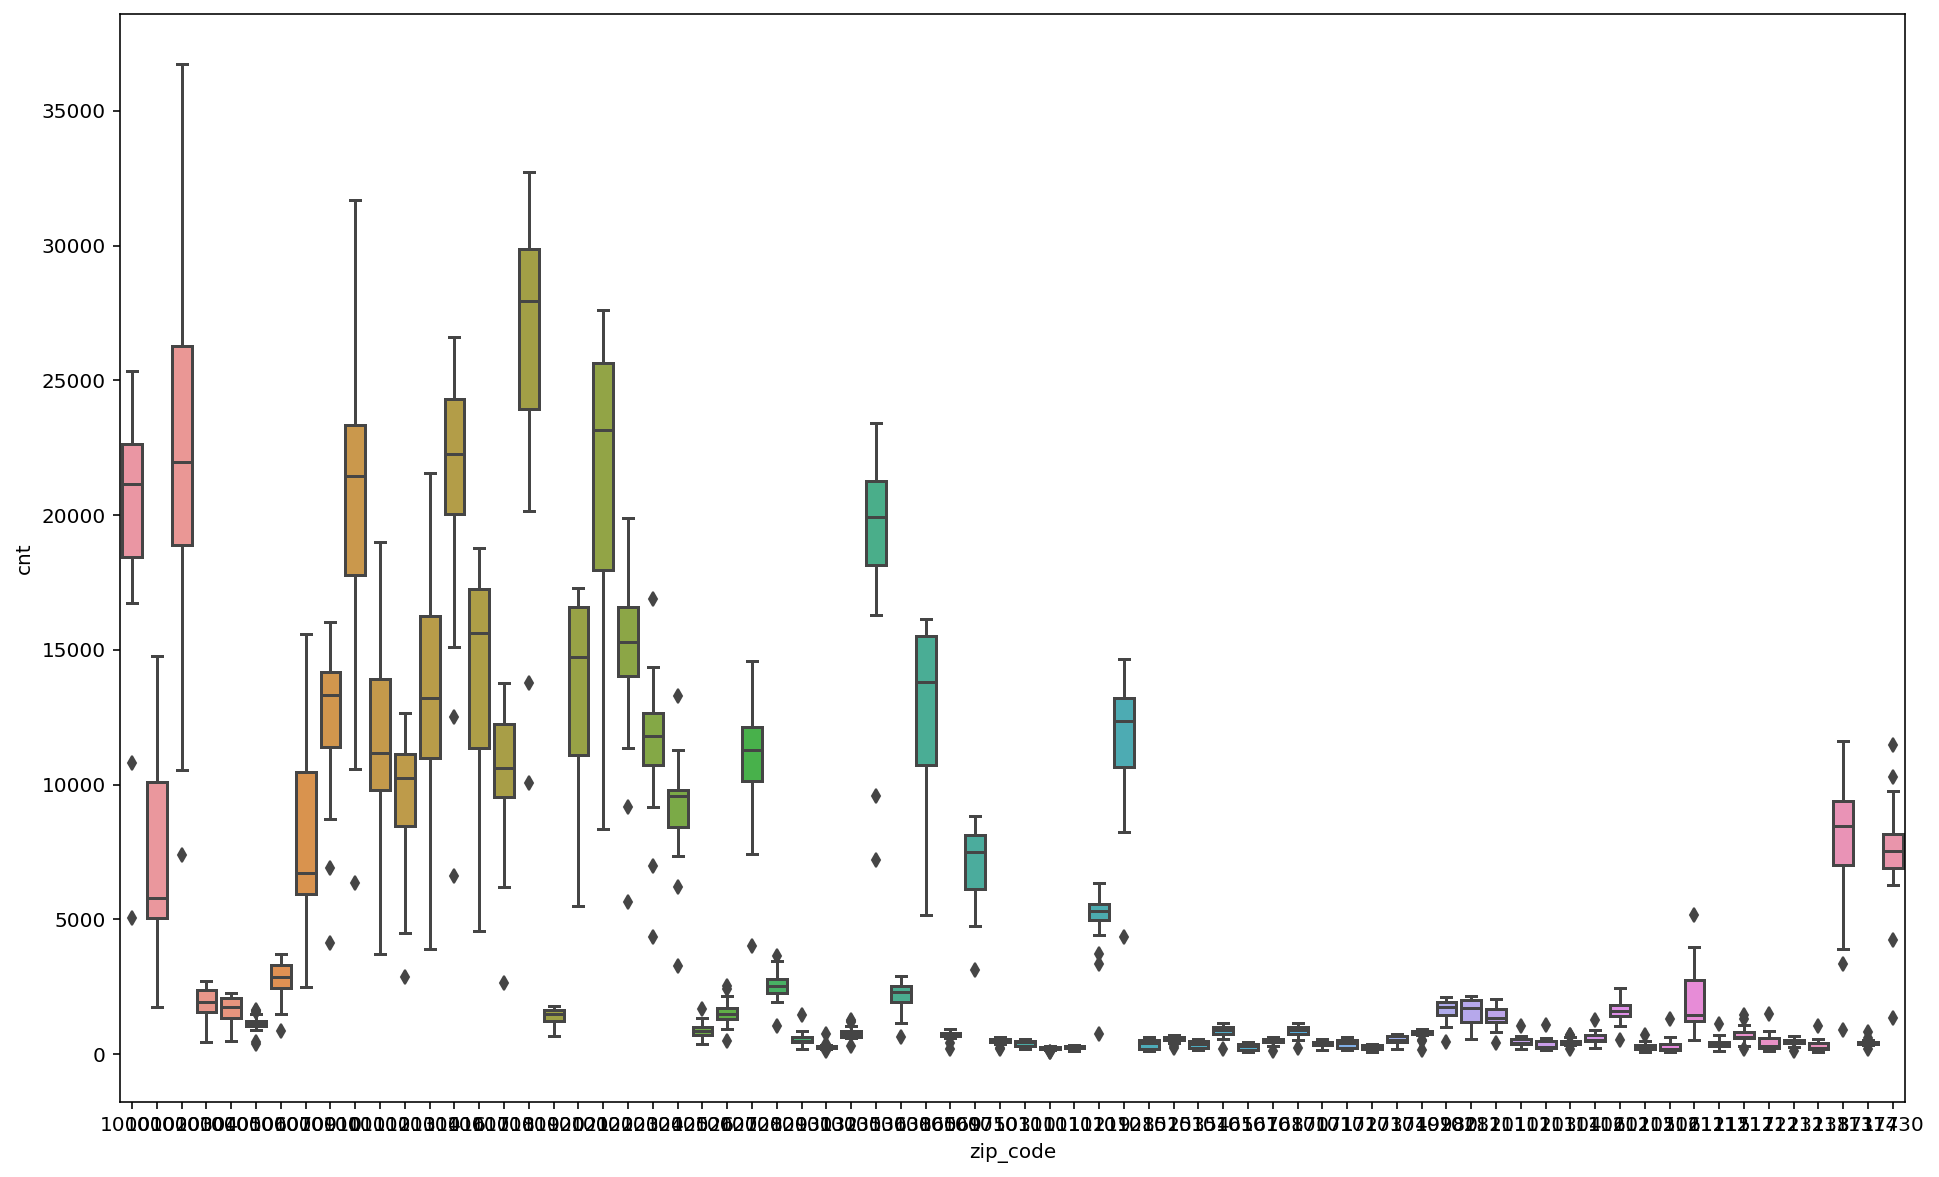

In [27]:
# use seaborn
plt.figure(figsize=(16,10))
sns.boxplot(x='zip_code', y='cnt', data=filter_zip_daily_df)

In [28]:
filter_zip_df[filter_zip_df['zip_code'] == '10001']

,zip_code,zip_code_geom,pickup_hour,cnt,date
120,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",2015-01-01 00:00:00,1221,2015-01-01
255,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",2015-01-01 01:00:00,1151,2015-01-01
346,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",2015-01-01 02:00:00,939,2015-01-01
546,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",2015-01-01 03:00:00,997,2015-01-01
724,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",2015-01-01 04:00:00,794,2015-01-01
...,...,...,...,...,...
86505,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",2015-01-31 19:00:00,1534,2015-01-31
86565,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",2015-01-31 20:00:00,1219,2015-01-31
86708,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",2015-01-31 21:00:00,1574,2015-01-31
86845,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",2015-01-31 22:00:00,1385,2015-01-31


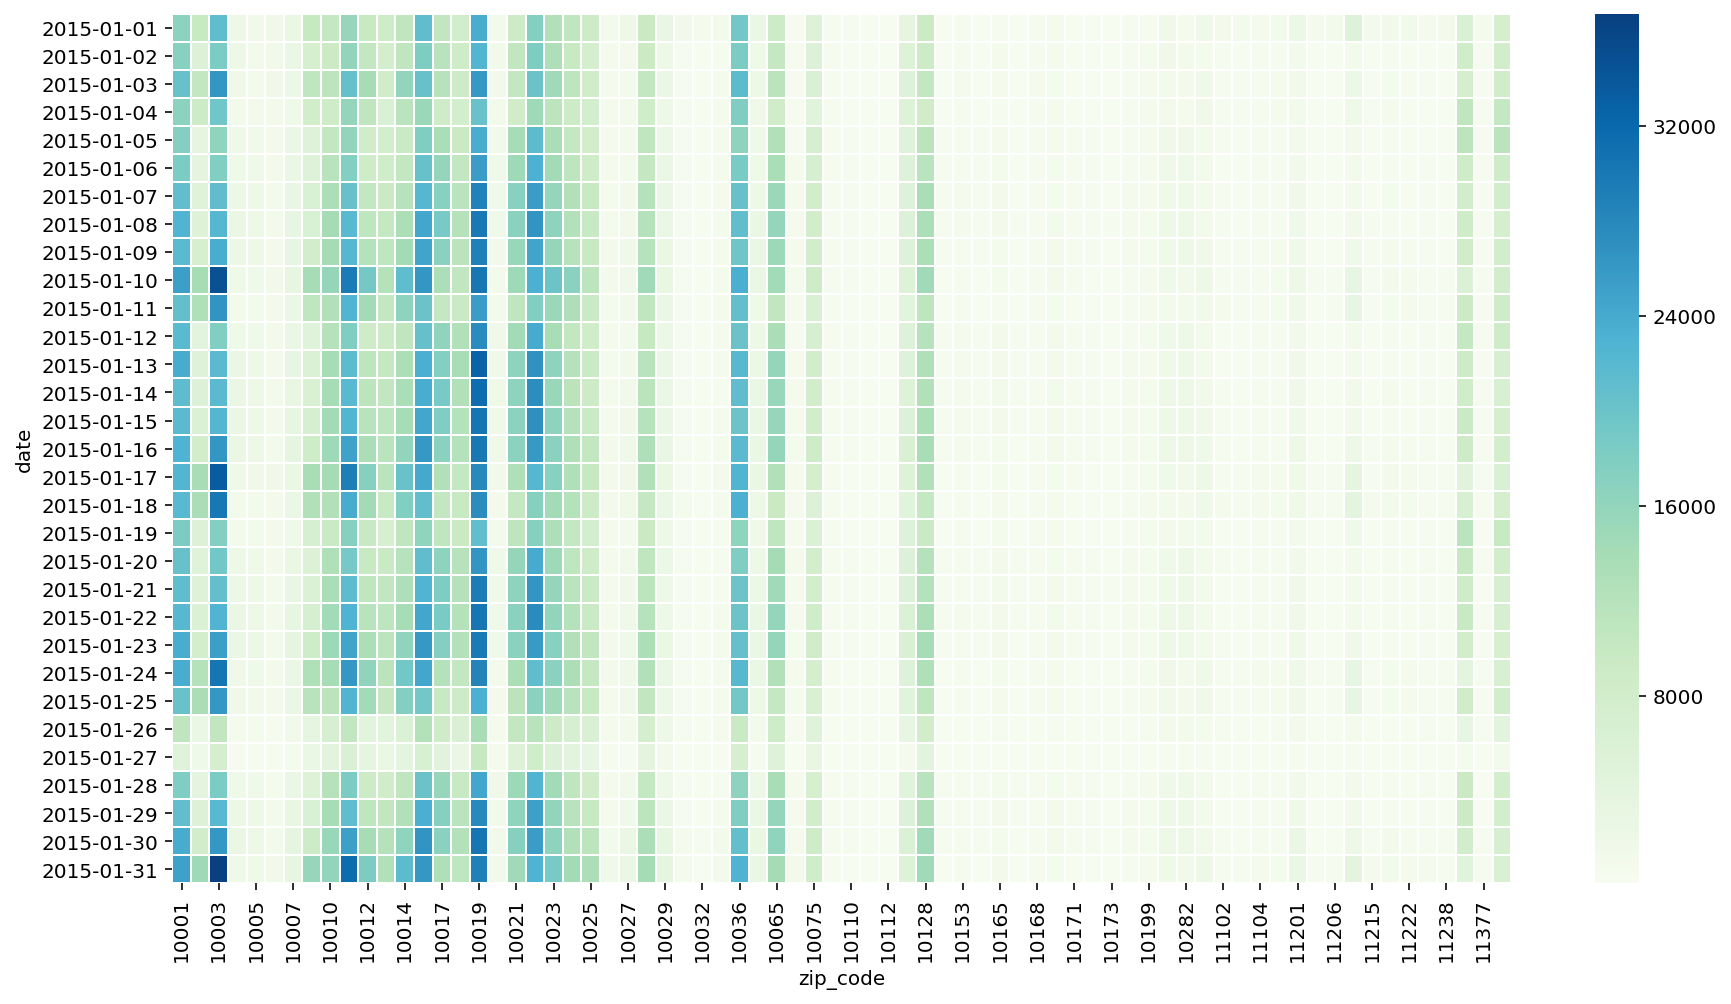

In [29]:
#hitmap
plt.figure(figsize=(15,8))
sns.heatmap(filter_zip_daily_df.pivot_table('cnt', index='date', columns='zip_code'),
           lw=.5, cmap='GnBu')

### hitmap per zipcode each time

In [31]:
filter_zip_df['hour'] = filter_zip_df['pickup_hour'].dt.hour

In [32]:
filter_zip_df.head(5)

,zip_code,zip_code_geom,pickup_hour,cnt,date,hour
0,10005,"POLYGON((-74.012508 40.706767, -74.0124 40.706...",2015-01-01,105,2015-01-01,0
1,10174,"POLYGON((-73.975558 40.752116, -73.976048 40.7...",2015-01-01,16,2015-01-01,0
3,11104,"POLYGON((-73.927635 40.736597, -73.927441 40.7...",2015-01-01,35,2015-01-01,0
6,10165,"POLYGON((-73.979287 40.752801, -73.979768 40.7...",2015-01-01,39,2015-01-01,0
7,10029,"POLYGON((-73.955528 40.788245, -73.955778 40.7...",2015-01-01,204,2015-01-01,0


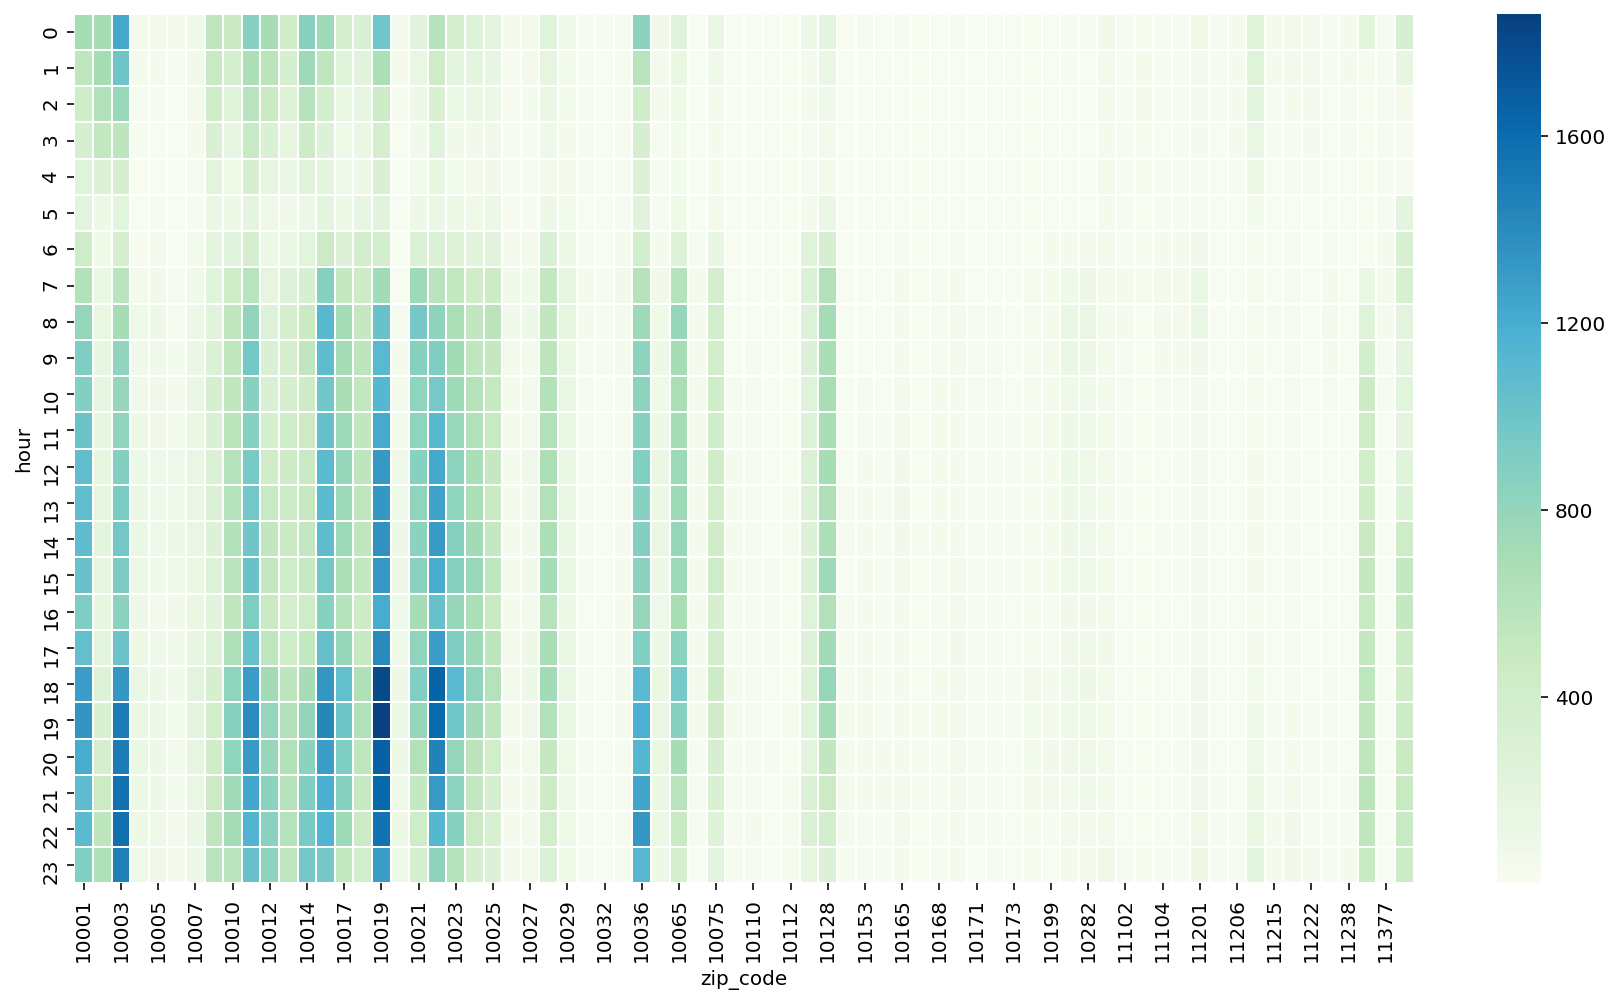

In [34]:
#hitmap
plt.figure(figsize=(15,8))
sns.heatmap(filter_zip_df.pivot_table('cnt', index='hour', columns='zip_code', aggfunc='mean'),
           lw=.5, cmap='GnBu')